Exercise Sheet 5 **Validation & Regularization**

In [1]:
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from numpy import linalg as LA
import scipy.cluster.vq as vq
mm = np.matmul

In [2]:
# abbreviations
# Xt       training input
# Xv       validation input
# Yt       training output
# Yv       validation output
# Xtc      centered training input
# Xtd      decorrelated training input
# Xtw      whitened training input
# Xtwm     monomials of training input after whitening
# Wtwmct   weight resulted from training set after cross validation training with optimum LambdaT
# Wvwmcg   weight resulted from validation set after cross validation training with optimum LambdaG
# Yp       predicted output

**5.1: Cross-validation**

**(a) Preprocessing**

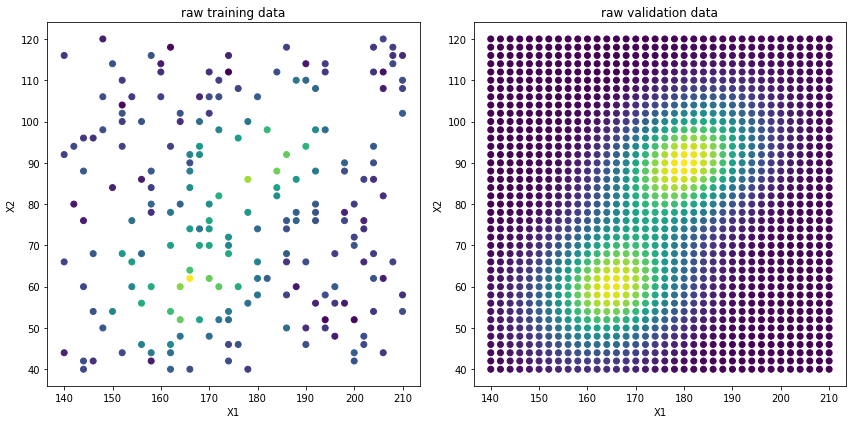

In [3]:
TrainingData = np.genfromtxt('TrainingRidge.csv',delimiter=',',skip_header=1).T
ValidationData = np.genfromtxt('ValidationRidge.csv',delimiter=',',skip_header=1).T
Xt = TrainingData[0:2,:]
Yt = TrainingData[2,:]
Xv = ValidationData[0:2,:]
Yv = ValidationData[2,:]

# plotting the raw data
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.scatter(Xt[0,:],Xt[1,:],c=Yt)
plt.xlabel('X1')
plt.ylabel('X2')
plt.title('raw training data')
plt.subplot(1,2,2)
plt.scatter(Xv[0,:],Xv[1,:],c=Yv)
plt.xlabel('X1')
plt.ylabel('X2')
plt.title('raw validation data')
plt.tight_layout()
plt.show()

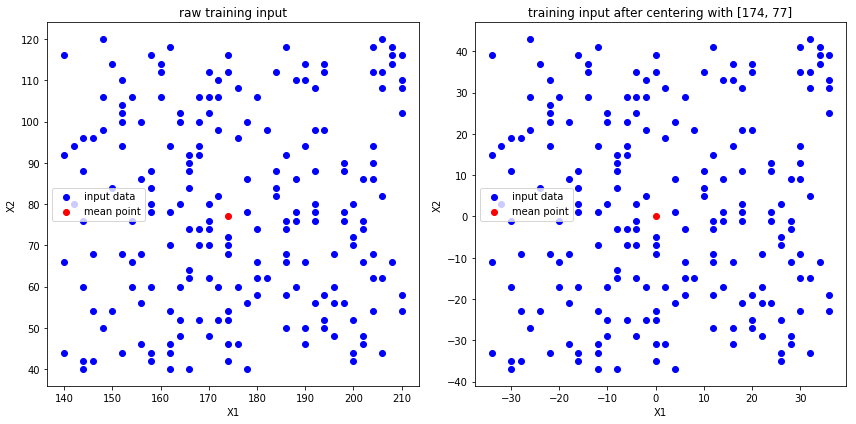

In [4]:
def centering(x):
    return np.median(x, axis=1)
xc = centering(Xt)
Xtc = Xt - xc.reshape(2,1) # centered inputs

# plotting (no computation value)
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.scatter(Xt[0,:],Xt[1,:],color='b',label='input data')
plt.scatter(xc[0],xc[1],color='r',label='mean point')
plt.xlabel('X1')
plt.ylabel('X2')
plt.title('raw training input')
plt.legend()
plt.subplot(1,2,2)
plt.scatter(Xtc[0,:],Xtc[1,:],color='b',label='input data')
plt.scatter(centering(Xtc)[0],centering(Xtc)[1],color='r',label='mean point')
plt.xlabel('X1')
plt.ylabel('X2')
plt.title('training input after centering with [%d, %d]'%(xc[0],xc[1]))
plt.tight_layout()
plt.legend()
plt.show()

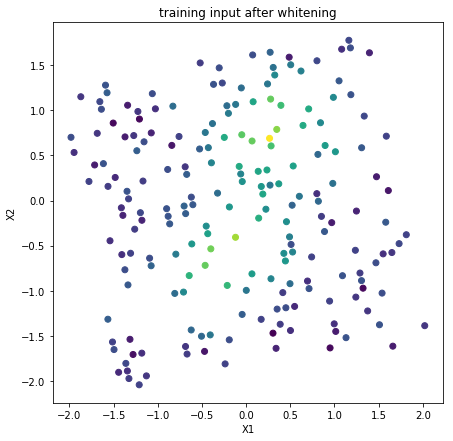

In [5]:
def covariance(x):
    return mm(x,x.T)/np.shape(x)[1]

# Covarience, eigenvalues and eigenvectors based on training data
C = covariance(Xtc)
A, V = LA.eig(C) # A: Eigenvalues     V: Eigenvectors

# whitening of the training data
Xtd = mm(V.T,Xtc) # decorrelation
Xtw = (np.sqrt(1/A).reshape(2,1)*Xtd) # whitening

# plotting (no computation value)
plt.figure(figsize=(7,7))
plt.scatter(Xtw[0,:],Xtw[1,:],c=Yt)
plt.xlabel('X1')
plt.ylabel('X2')
plt.title('training input after whitening')
plt.show()

In [6]:
# test of successful whitening:
print(np.round(covariance(Xtw),6))
# should result in Identity matrix

[[1. 0.]
 [0. 1.]]


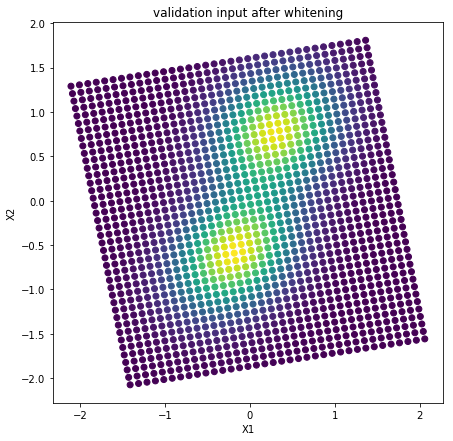

In [7]:
# whitening of the validation data
Xvc = Xv - xc.reshape(2,1) # centered the validation input
Xvd = mm(V.T,Xvc) # decorrelation
Xvw = (np.sqrt(1/A).reshape(2,1)*Xvd) # whitening

# plotting (no computation value)
plt.figure(figsize=(7,7))
plt.scatter(Xvw[0,:],Xvw[1,:],c=Yv)
plt.xlabel('X1')
plt.ylabel('X2')
plt.title('validation input after whitening')
plt.show()

In [8]:
# Xtw is the training input after whitening
# Xvw is the validation input after whitening
# A is the eigenvalues matrix
# V is the eigenvectors matrix

**(b) Plot monomials**

In [9]:
# monomial
def arisum(n): # arithmetic sum of combination sequences only for X with dim. 2
    s = 0
    for i in range(n+2):
        s += i
    return s

def monomial(X,k): # calculating the monomial series of order k
    Xm = np.zeros((arisum(k),np.shape(X)[1]))
    for j in range(np.shape(X)[1]):
        i = 0
        for n in range(k+1):
            l = n
            m = 0
            while l+m == n and l>= 0:
                Xm[i,j] = ((X[0,j]**l)*(X[1,j]**m))
                l -= 1
                m += 1
                i += 1
            if i == arisum(k):
                break
    return Xm

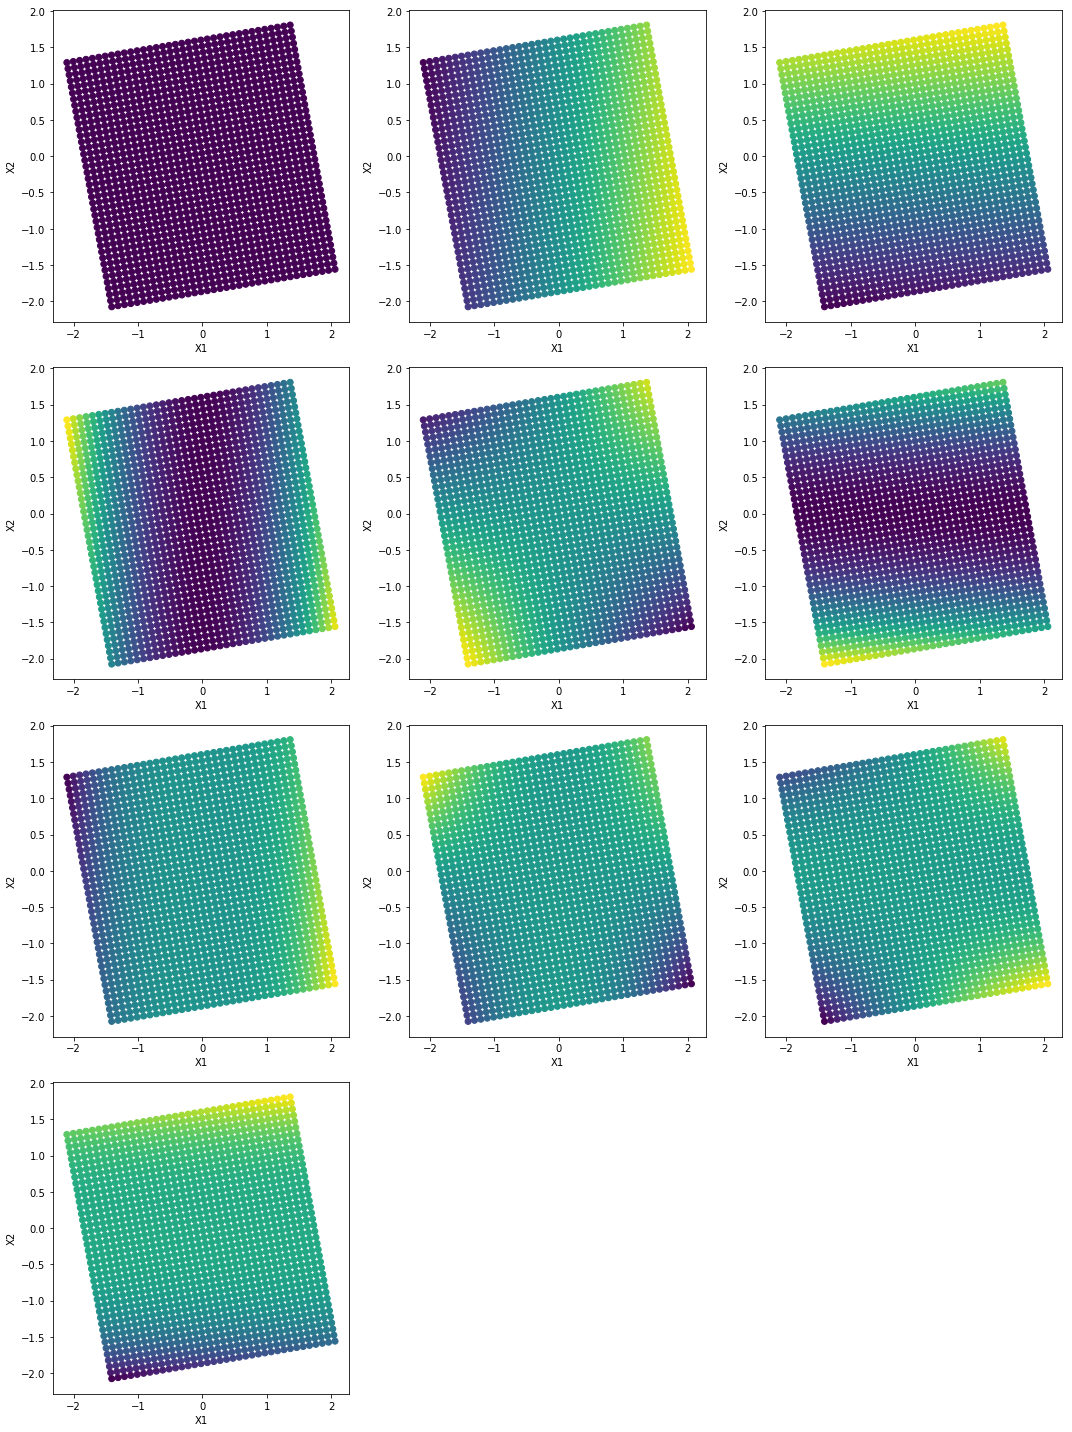

In [10]:
Xvwm3 = monomial(Xvw,3) # monomials using the white validation set

# plotting (no computation value)
# the monomial as a function of x1 and x1
plt.figure(figsize=(15,20))
for i in range(10):
    plt.subplot(4,3,i+1)
    plt.scatter(Xvw[0,:],Xvw[1,:],c=Xvwm3[i,:])
    plt.xlabel('X1')
    plt.ylabel('X2')
plt.tight_layout()
plt.show()

In [11]:
Xtwm = monomial(Xtw,9) # monomials of training set
Xvwm = monomial(Xvw,9) # monomials of validation set

Wtwm = mm(LA.inv(mm(Xtwm,Xtwm.T)),mm(Xtwm,Yt.T)) # weights as validation set
Wvwm = mm(LA.inv(mm(Xvwm,Xvwm.T)),mm(Xvwm,Yv.T)) # weights as training set

Yts = mm(Xtwm.T,Wtwm) # simulated output based on training data
Yvs = mm(Xvwm.T,Wvwm) # simulated output based on validation data

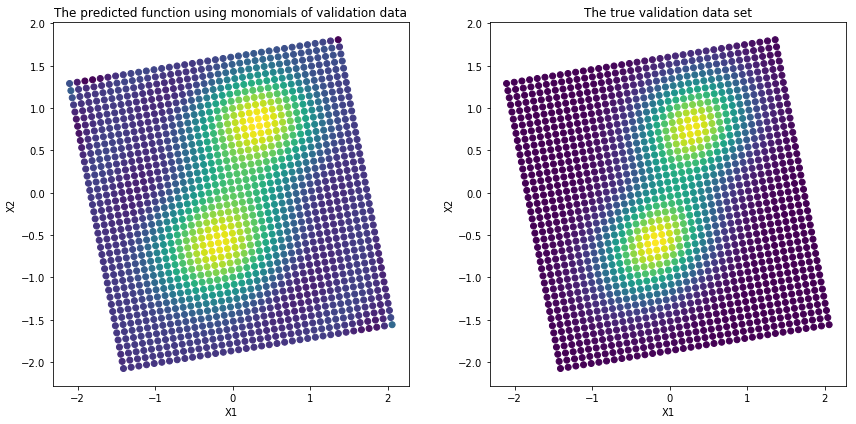

In [12]:
# prediction vs validation
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.scatter(Xvw[0,:],Xvw[1,:],c=Yvs)
plt.xlabel('X1')
plt.ylabel('X2')
plt.title('The predicted function using monomials of validation data')
plt.subplot(1,2,2)
plt.scatter(Xvw[0,:],Xvw[1,:],c=Yv)
plt.xlabel('X1')
plt.ylabel('X2')
plt.title('The true validation data set')
plt.tight_layout()
plt.show()

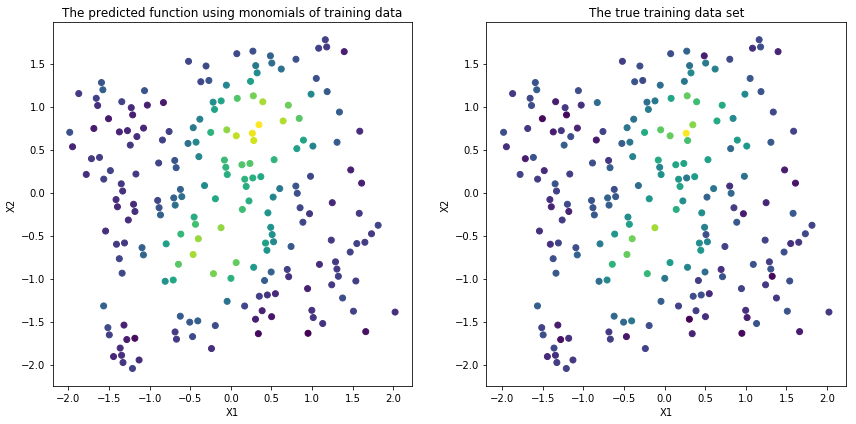

In [13]:
# prediction vs Training
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.scatter(Xtw[0,:],Xtw[1,:],c=Yts)
plt.xlabel('X1')
plt.ylabel('X2')
plt.title('The predicted function using monomials of training data')
plt.subplot(1,2,2)
plt.scatter(Xtw[0,:],Xtw[1,:],c=Yt)
plt.xlabel('X1')
plt.ylabel('X2')
plt.title('The true training data set')
plt.tight_layout()
plt.show()

**(c) apply regularization using a weight-decay term**

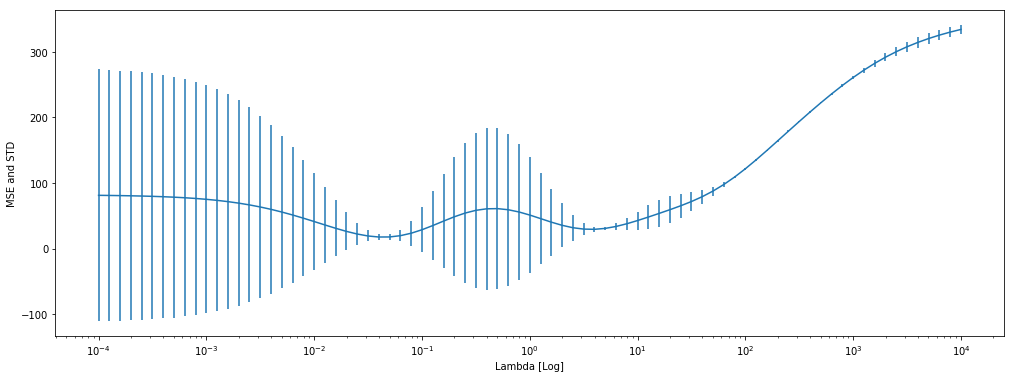

In [14]:
def _MSE_(W,X,Y):
    Ys = mm(W.T,X)
    sqe = ((Y-Ys)**2)
    return np.sum(sqe)/np.shape(X)[1]

setLambda = 10**(np.linspace(-4,4,81,endpoint=True))
ebd = [[],[],[]] # error bar data: [Lambda, MSE, STD]
for Lambda in setLambda:
    ident = np.identity(55)*Lambda
    Err = []
    for fold in range(10):
        vind = list(range(20*fold,20*(fold+1)))
        tind = list(range(0,20*fold))+list(range(20*(fold+1),200))
        Xcv = Xtwm[:,vind] # validation X for cross validation
        Xct = Xtwm[:,tind] # Training X for cross validation
        Ycv = Yt[vind] # validation Y for cross validation
        Yct = Yt[tind] # training Y for cross validation
        Wtwmc = mm(LA.inv(mm(Xct,Xct.T)+ident),mm(Xct,Yct.T)).reshape(55,1)
        Err.append(_MSE_(Wtwmc,Xtwm,Yt)) # calculated the whole training set
    Err = np.array(Err)
    mse = np.sum(Err)/10
    std = np.std(Err)
    ebd[0].append(Lambda)
    ebd[1].append(mse)
    ebd[2].append(std)

plt.figure(figsize=(17,6))
ax = plt.subplot()
plt.errorbar(ebd[0], ebd[1], yerr=ebd[2])
ax.set_xscale("log")
plt.xlabel('Lambda [Log]')
plt.ylabel('MSE and STD')
plt.show()

In [15]:
LambdaT = ebd[0][np.argmin(ebd[1])]
print('The Lambda at which the MSE is minimum'
      ' over the whole training set:\n'
      'best regularization parameter is %.4f'%LambdaT)

The Lambda at which the MSE is minimum over the whole training set:
best regularization parameter is 0.0398


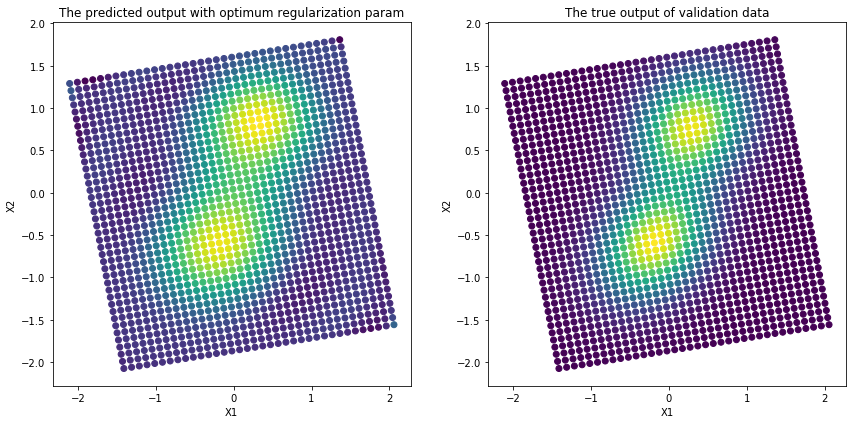

In [16]:
# using best regularization parameter
ident = np.identity(55)*LambdaT
Wvwmc = mm(LA.inv(mm(Xvwm,Xvwm.T)+ident),mm(Xvwm,Yv.T)).reshape(55,1)
Yp = mm(Wvwmc.T,Xvwm)

# plotting the raw data
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.scatter(Xvw[0,:],Xvw[1,:],c=Yp[0,:])
plt.xlabel('X1')
plt.ylabel('X2')
plt.title('The predicted output with optimum regularization param')
plt.subplot(1,2,2)
plt.scatter(Xvw[0,:],Xvw[1,:],c=Yv)
plt.xlabel('X1')
plt.ylabel('X2')
plt.title('The true output of validation data')
plt.tight_layout()
plt.show()

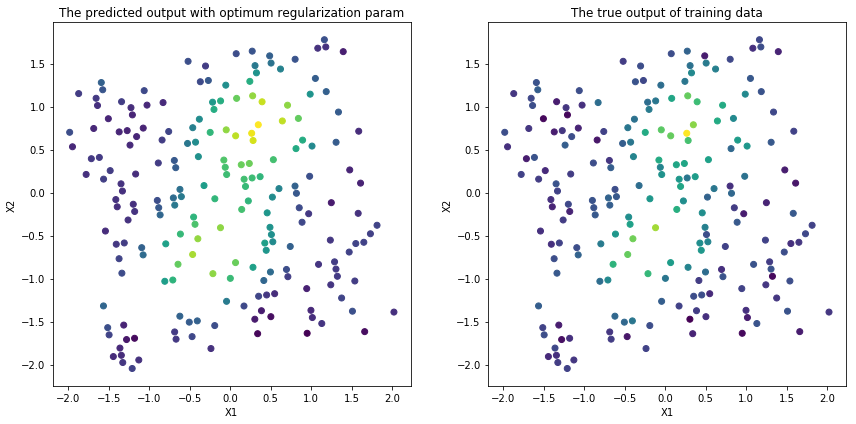

In [17]:
# using best regularization parameter
ident = np.identity(55)*LambdaT
Wtwmc = mm(LA.inv(mm(Xtwm,Xtwm.T)+ident),mm(Xtwm,Yt.T)).reshape(55,1)
Yp = mm(Wtwmc.T,Xtwm)

# plotting the raw data
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.scatter(Xtw[0,:],Xtw[1,:],c=Yp[0,:])
plt.xlabel('X1')
plt.ylabel('X2')
plt.title('The predicted output with optimum regularization param')
plt.subplot(1,2,2)
plt.scatter(Xtw[0,:],Xtw[1,:],c=Yt)
plt.xlabel('X1')
plt.ylabel('X2')
plt.title('The true output of training data')
plt.tight_layout()
plt.show()

**(d) Compare empirical estimates of bias and variance with the true generalization error**

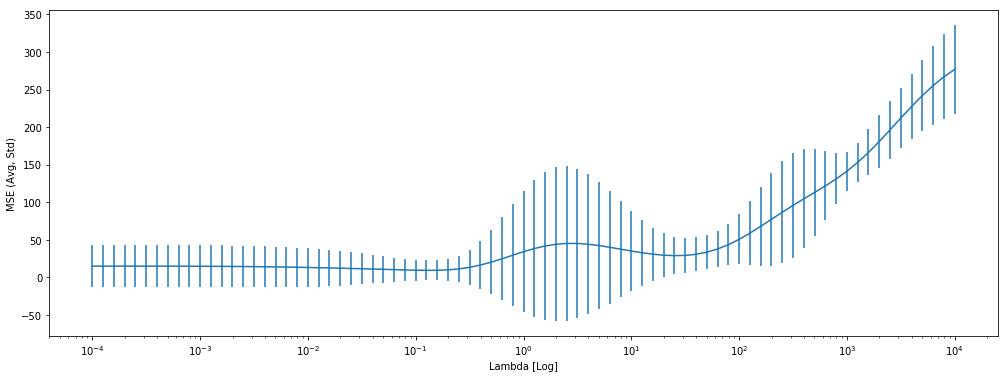

In [26]:
def _MSE_(W,X,Y):
    Ys = mm(W.T,X)
    sqe = ((Y-Ys)**2)
    return np.sum(sqe)/np.shape(X)[1]

setLambda = 10**(np.linspace(-4,4,81,endpoint=True))
ebd = [[],[],[]] # error bar data: [Lambda, MSE, STD]
for Lambda in setLambda:
    ident = np.identity(55)*Lambda
    Err = []
    for fold in range(9): # 9 folds of 164 samples
        vind = list(range(164*fold,164*(fold+1))) #validation indecis
        tind = list(range(0,164*fold))+list(range(164*(fold+1),1476)) # training indecis
        Xcv = Xvwm[:,vind] # validation X for cross validation
        Xct = Xvwm[:,tind] # Training X for cross validation
        Ycv = Yv[vind] # validation Y for cross validation
        Yct = Yv[tind] # training Y for cross validation
        Wvwmc = mm(LA.inv(mm(Xct,Xct.T)+ident),mm(Xct,Yct.T)).reshape(55,1)
        Err.append(_MSE_(Wvwmc,Xvwm,Yv)) # calculated the whole training set
    Err = np.array(Err)
    mse = np.sum(Err)/9
    std = np.std(Err)
    ebd[0].append(Lambda)
    ebd[1].append(mse)
    ebd[2].append(std)

plt.figure(figsize=(17,6))
ax = plt.subplot()
plt.errorbar(ebd[0], ebd[1], yerr=ebd[2])
ax.set_xscale("log")
plt.xlabel('Lambda [Log]')
plt.ylabel('MSE (Avg, Std)')
plt.show()

In [19]:
LambdaG = ebd[0][np.argmin(ebd[1])]
print('The Lambda at which the MSE is minimum'
      ' over the whole validation set:\n'
      'best regularization parameter is %.4f'%LambdaG)

The Lambda at which the MSE is minimum over the whole validation set:
best regularization parameter is 0.1259


The $\lambda$G (= 0.1259) is different than $\lambda$T (= 0.0398) but the difference is small.

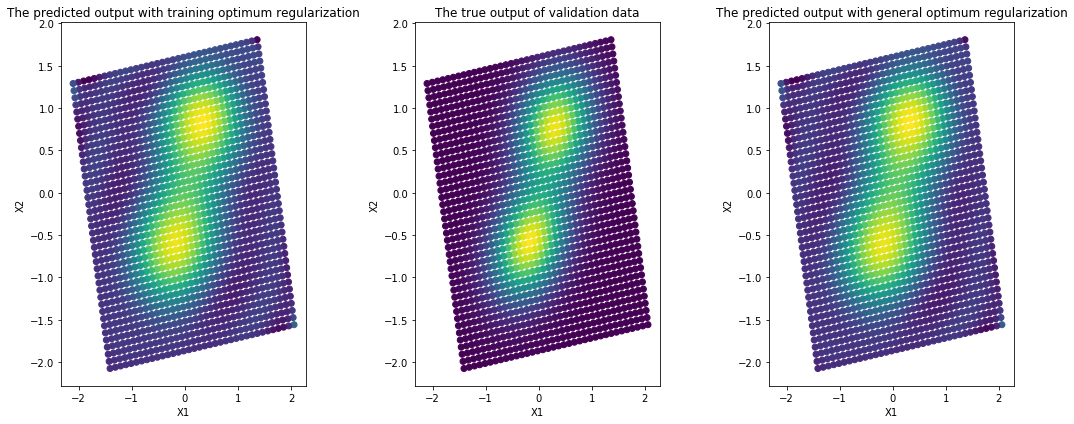

In [20]:
# using best regularization parameter
identg = np.identity(55)*LambdaG
Wvwmcg = mm(LA.inv(mm(Xvwm,Xvwm.T)+identg),mm(Xvwm,Yv.T)).reshape(55,1)
Ypg = mm(Wvwmcg.T,Xvwm)

identt = np.identity(55)*LambdaT
Wvwmct = mm(LA.inv(mm(Xvwm,Xvwm.T)+identt),mm(Xvwm,Yv.T)).reshape(55,1)
Ypt = mm(Wvwmct.T,Xvwm)

# plotting the raw data
plt.figure(figsize=(15,6))
plt.subplot(1,3,1)
plt.scatter(Xvw[0,:],Xvw[1,:],c=Ypt[0,:])
plt.xlabel('X1')
plt.ylabel('X2')
plt.title('The predicted output with training optimum regularization')
plt.subplot(1,3,2)
plt.scatter(Xvw[0,:],Xvw[1,:],c=Yv)
plt.xlabel('X1')
plt.ylabel('X2')
plt.title('The true output of validation data')
plt.subplot(1,3,3)
plt.scatter(Xvw[0,:],Xvw[1,:],c=Ypg[0,:])
plt.xlabel('X1')
plt.ylabel('X2')
plt.title('The predicted output with general optimum regularization')
plt.tight_layout()
plt.show()

In [21]:
print('the mean square error for training lambda is %.1f\n'
      'and for the generalized lambda is %.1f'
      %((np.sum((Yv-Ypt)**2))/1476,(np.sum((Yv-Ypg)**2))/1476))

the mean square error for training lambda is 1.7
and for the generalized lambda is 1.8


**(e) Compare generalization and training optimal λ**

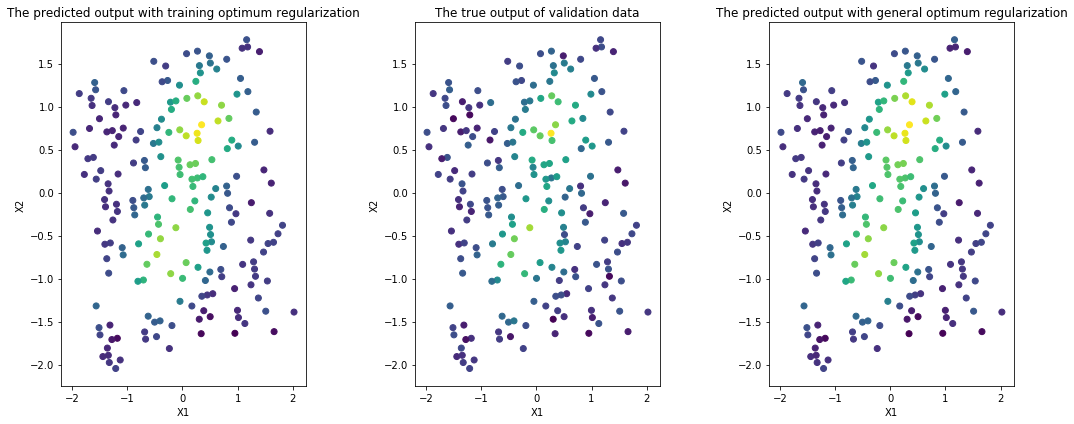

In [22]:
# using best regularization parameter
identg = np.identity(55)*LambdaG
Wtwmcg = mm(LA.inv(mm(Xtwm,Xtwm.T)+identg),mm(Xtwm,Yt.T)).reshape(55,1)
Ypg = mm(Wtwmcg.T,Xtwm)

identt = np.identity(55)*LambdaT
Wtwmct = mm(LA.inv(mm(Xtwm,Xtwm.T)+identt),mm(Xtwm,Yt.T)).reshape(55,1)
Ypt = mm(Wtwmct.T,Xtwm)

# plotting the raw data
plt.figure(figsize=(15,6))
plt.subplot(1,3,1)
plt.scatter(Xtw[0,:],Xtw[1,:],c=Ypt[0,:])
plt.xlabel('X1')
plt.ylabel('X2')
plt.title('The predicted output with training optimum regularization')
plt.subplot(1,3,2)
plt.scatter(Xtw[0,:],Xtw[1,:],c=Yt)
plt.xlabel('X1')
plt.ylabel('X2')
plt.title('The true output of validation data')
plt.subplot(1,3,3)
plt.scatter(Xtw[0,:],Xtw[1,:],c=Ypg[0,:])
plt.xlabel('X1')
plt.ylabel('X2')
plt.title('The predicted output with general optimum regularization')
plt.tight_layout()
plt.show()

In [23]:
print('the mean square error for training lambda is %.1f\n'
      'and for the generalized lambda is %.1f'
      %((np.sum((Yt-Ypt)**2))/200,(np.sum((Yt-Ypg)**2))/200))

the mean square error for training lambda is 13.5
and for the generalized lambda is 14.8
